#Mounting and Project Environment

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [0]:
#%cd /content
#!ls gdrive
#%cd gdrive/MyDrive/comp4651/project
#!ls data

#Initialization

In [0]:
import numpy as np
import pandas as pd
import os
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import random

In [0]:
display(dbutils.fs.ls("/FileStore/tables/Company.csv"))

path,name,size
dbfs:/FileStore/tables/Company.csv,Company.csv,124


In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v2.4.3 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
company_df = spark.read.csv("/FileStore/tables/Company.csv", header=True, inferSchema=True)
company_values_df = spark.read.csv("/FileStore/tables/CompanyValues.csv", header=True, inferSchema=True)
company_tweet_df = spark.read.csv("/FileStore/tables/Company_Tweet.csv", header=True, inferSchema=True)
tweet_df = spark.read.csv("/FileStore/tables/Tweet.csv", header=True, inferSchema=True)

In [0]:
display(company_df)

ticker_symbol,company_name
AAPL,apple
GOOG,Google Inc
GOOGL,Google Inc
AMZN,Amazon.com
TSLA,Tesla Inc
MSFT,Microsoft


In [0]:
display(company_values_df.limit(5))

ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
AAPL,2020-05-29T00:00:00.000+0000,317.94,38399530,319.25,321.15,316.47
AAPL,2020-05-28T00:00:00.000+0000,318.25,33449100,316.77,323.44,315.63
AAPL,2020-05-27T00:00:00.000+0000,318.11,28236270,316.14,318.71,313.09
AAPL,2020-05-26T00:00:00.000+0000,316.73,31380450,323.5,324.24,316.5
AAPL,2020-05-22T00:00:00.000+0000,318.89,20450750,315.77,319.23,315.35


In [0]:
display(company_tweet_df.limit(5))

tweet_id,ticker_symbol
550803612197457920,AAPL
550803610825928706,AAPL
550803225113157632,AAPL
550802957370159104,AAPL
550802855129382912,AAPL


In [0]:
display(tweet_df.limit(5))

tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! http://profit.ly/1MnD8s?aff=202 Learn #howtotrade http://bit.ly/1c1NljX $EXE $WATT $IMRS $CACH $GMO",0,0,1
550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aapl bid up 45 cents after hours after non stop selling in trading hours,0,0,0
550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT $DVN $IBM $AMZN $F $APA $GM $MS $HAL $DIS $MCD $BMY $XOM more@ http://12Stocks.com/sp100,0,0,0
550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recall Tally Higher https://pic.twitter.com/WIIc1lW7hW @ProTradersNews http://growword.com/2015/01/01/0246.html… @theferrarifan,0,0,1
550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days http://ow.ly/GDks0 #swingtrading #forecast #techstock $MWW $AAPL $TSLA,0,0,1


In [0]:
#tweet_df = tweet_df.join(company_tweet_df,tweet_df.tweet_id ==  company_tweet_df.tweet_id,"inner")
#display(tweet_df.limit(5))

In [0]:
print(company_df.count())
print(company_values_df.count())
print(company_tweet_df.count())
print(tweet_df.count())

6
17528
4336445
3717964

In [0]:
#tweet_df.select('writer').distinct().show(35, False)

In [0]:
#display(tweet_df.select('writer').groupby('writer').count().orderBy("count", ascending=False))

In [0]:
tweet_df.printSchema()

root
-- tweet_id: long (nullable = true)
-- writer: string (nullable = true)
-- post_date: integer (nullable = true)
-- body: string (nullable = true)
-- comment_num: string (nullable = true)
-- retweet_num: string (nullable = true)
-- like_num: string (nullable = true)

In [0]:
tweet_df = tweet_df.withColumn("ts_post_date", from_unixtime(tweet_df["post_date"])).drop(tweet_df["post_date"])
tweet_df = tweet_df.withColumn("post_date_ts", to_timestamp(tweet_df["ts_post_date"])).drop(tweet_df["ts_post_date"])
tweet_df.show(5)

+------------------+---------------+--------------------+-----------+-----------+--------+-------------------+
 tweet_id| writer| body|comment_num|retweet_num|like_num| post_date_ts|
+------------------+---------------+--------------------+-----------+-----------+--------+-------------------+
550441509175443456|VisualStockRSRC|lx21 made $10,008...| 0| 0| 1|2015-01-01 00:00:57|
550441672312512512| KeralaGuy77|Insanity of today...| 0| 0| 0|2015-01-01 00:01:36|
550441732014223360| DozenStocks|S&P100 #Stocks Pe...| 0| 0| 0|2015-01-01 00:01:50|
550442977802207232| ShowDreamCar|$GM $TSLA: Volksw...| 0| 0| 1|2015-01-01 00:06:47|
550443807834402816| i_Know_First|Swing Trading: Up...| 0| 0| 1|2015-01-01 00:10:05|
+------------------+---------------+--------------------+-----------+-----------+--------+-------------------+
only showing top 5 rows

In [0]:
#tweet_df = tweet_df.join(company_tweet_df,tweet_df.tweet_id ==  company_tweet_df.tweet_id,"inner")
#tweet_df.show(5)

In [0]:
tweet_df.printSchema()

root
-- tweet_id: long (nullable = true)
-- writer: string (nullable = true)
-- body: string (nullable = true)
-- comment_num: string (nullable = true)
-- retweet_num: string (nullable = true)
-- like_num: string (nullable = true)
-- post_date_ts: timestamp (nullable = true)

In [0]:
company_values_df.printSchema()

root
-- ticker_symbol: string (nullable = true)
-- day_date: timestamp (nullable = true)
-- close_value: double (nullable = true)
-- volume: integer (nullable = true)
-- open_value: double (nullable = true)
-- high_value: double (nullable = true)
-- low_value: double (nullable = true)

In [0]:
company_values_df = company_values_df.withColumn("open_close_diff", company_values_df["close_value"]-company_values_df["open_value"])
company_values_df = company_values_df.withColumn("low_high_diff", company_values_df["high_value"]-company_values_df["low_value"])
company_values_df.show(5)

+-------------+-------------------+-----------+--------+----------+----------+---------+-------------------+------------------+
ticker_symbol| day_date|close_value| volume|open_value|high_value|low_value| open_close_diff| low_high_diff|
+-------------+-------------------+-----------+--------+----------+----------+---------+-------------------+------------------+
 AAPL|2020-05-29 00:00:00| 317.94|38399530| 319.25| 321.15| 316.47|-1.3100000000000023| 4.67999999999995|
 AAPL|2020-05-28 00:00:00| 318.25|33449100| 316.77| 323.44| 315.63| 1.4800000000000182| 7.810000000000002|
 AAPL|2020-05-27 00:00:00| 318.11|28236270| 316.14| 318.71| 313.09| 1.9700000000000273|5.6200000000000045|
 AAPL|2020-05-26 00:00:00| 316.73|31380450| 323.5| 324.24| 316.5| -6.769999999999982| 7.740000000000009|
 AAPL|2020-05-22 00:00:00| 318.89|20450750| 315.77| 319.23| 315.35| 3.1200000000000045|3.8799999999999955|
+-------------+-------------------+-----------+--------+----------+----------+---------+-------------------+------------------+
only showing top 5 rows

In [0]:
company_values_df.printSchema()

root
-- ticker_symbol: string (nullable = true)
-- day_date: timestamp (nullable = true)
-- close_value: double (nullable = true)
-- volume: integer (nullable = true)
-- open_value: double (nullable = true)
-- high_value: double (nullable = true)
-- low_value: double (nullable = true)
-- open_close_diff: double (nullable = true)
-- low_high_diff: double (nullable = true)

In [0]:
#display(company_values_df.filter(year("day_date")=='2016').filter(dayofyear("day_date")>=100)\
#        .groupBy(dayofyear("day_date")).count().orderBy(dayofyear("day_date")))

In [0]:
sqlContext.registerDataFrameAsTable(company_values_df, "company_values")

In [0]:
df = sqlContext.table("company_values")

display(df.describe())

summary,ticker_symbol,close_value,volume,open_value,high_value,low_value,open_close_diff,low_high_diff
count,17528,17528,17528,17528,17528,17528,17528,17528
mean,null,455.1670397193078,2.0254414354290277E7,455.3144514776372,459.7105965312757,450.4666941864371,-0.14741175832952963,9.24390234481966
stddev,null,469.32458303902496,3.3227326734178826E7,469.5882910261432,473.7716914201341,464.7947907107297,9.363752495207308,12.597577154460563
min,AAPL,15.8,7932,16.14,16.63,14.98,-121.11999999999989,0.14999999999999858
max,TSLA,2497.94,462442329,2500.0,2525.45,2467.27,128.8699999999999,170.73829999999998


In [0]:
#bigDF = company_values_df.toPandas()
#bigDF.plot()
#display(plt.show())

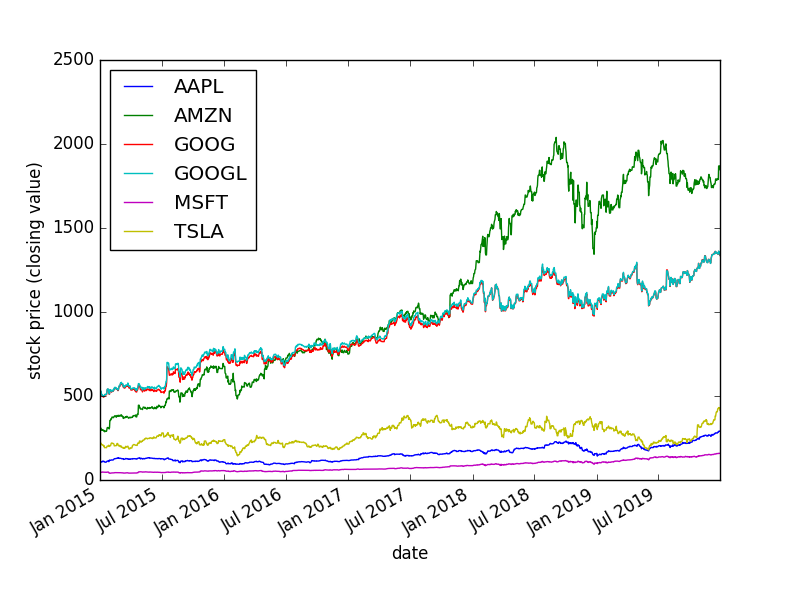

In [0]:
plt.clf()
query_0 = spark.sql('SELECT ticker_symbol, day_date, close_value FROM company_values WHERE day_date>="2015-01-01" AND day_date<="2019-12-31"').toPandas()

query_0.set_index('day_date', inplace=True)
query_0.groupby('ticker_symbol')['close_value'].plot(legend=True, alpha=1)
plt.xlabel("date")
plt.ylabel('stock price (closing value)')
display(plt.show())

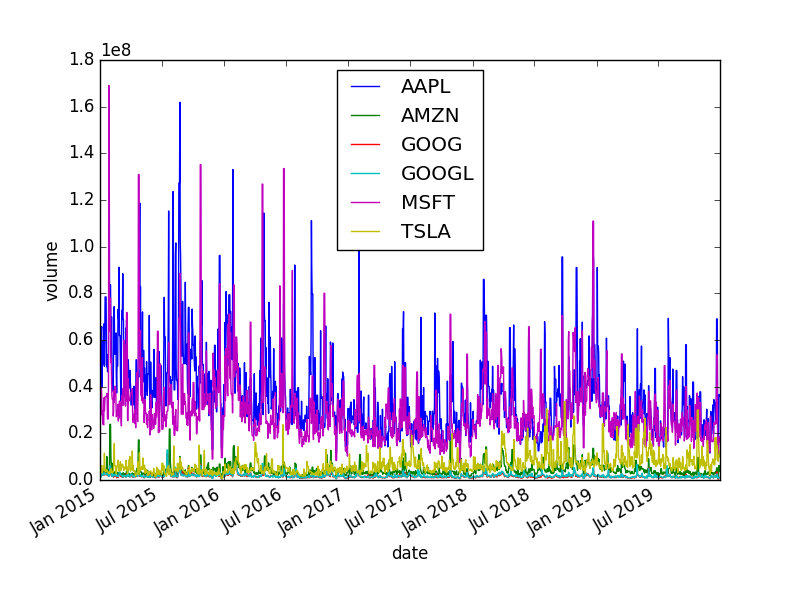

In [0]:
plt.clf()
query_1 = spark.sql('SELECT ticker_symbol, day_date, volume FROM company_values WHERE day_date>="2015-01-01" AND day_date<="2019-12-31"').toPandas()

query_1.set_index('day_date', inplace=True)
query_1.groupby('ticker_symbol')['volume'].plot(legend=True, alpha=1)
plt.xlabel("date")
plt.ylabel('volume')
display(plt.show())

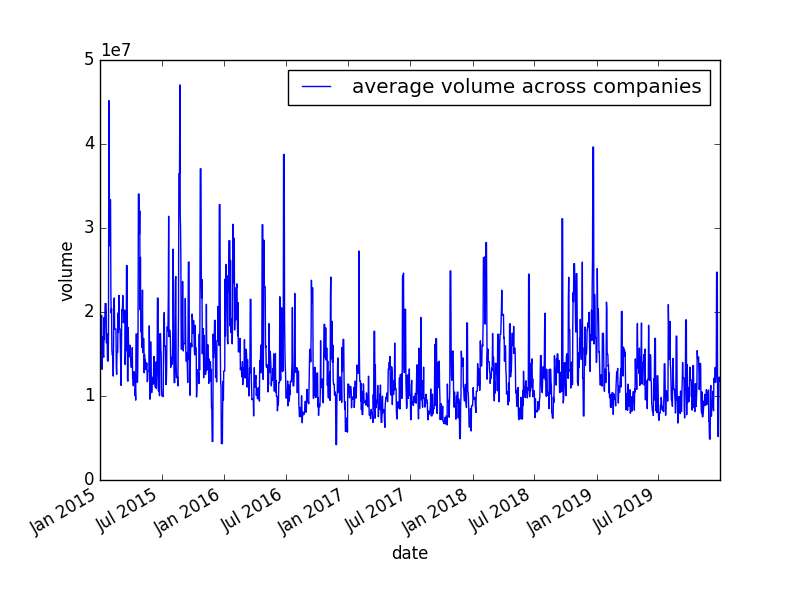

In [0]:
plt.clf()
query_2_rdd = spark.sql('SELECT day_date, avg(volume) as avg_volume FROM company_values WHERE day_date>="2015-01-01" AND day_date<="2019-12-31" GROUP BY day_date')
query_2 = query_2_rdd.toPandas()

query_2.set_index('day_date', inplace=True)
query_2.plot(legend=True)
plt.ylabel('volume')
plt.xlabel("date")
L=plt.legend()
L.get_texts()[0].set_text('average volume across companies')
display(plt.show())

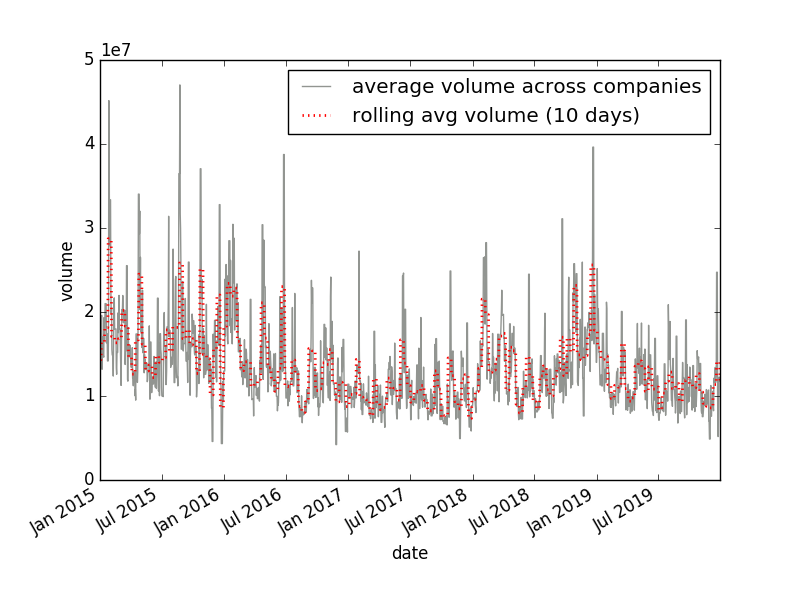

In [0]:
plt.clf()

query_2_rdd = spark.sql('SELECT day_date, avg(volume) as avg_volume FROM company_values WHERE day_date>="2015-01-01" AND day_date<="2019-12-31" GROUP BY day_date')

query_2 = query_2_rdd.toPandas()
query_2.set_index('day_date', inplace=True)
query_2.plot(legend=True, color="#929591")
plt.xlabel("date")
plt.ylabel('volume')

query_2b = query_2_rdd
query_2b = query_2b.withColumn('rolling_average', avg(query_2b["avg_volume"]).over(Window.partitionBy(window("day_date", "10 days")))).drop("avg_volume").orderBy("day_date").toPandas()

plt.plot(query_2b["day_date"], query_2b["rolling_average"], linestyle=':', alpha=1, c="red", linewidth=2)
L=plt.legend()
L.get_texts()[0].set_text('average volume across companies')
L.get_texts()[1].set_text("rolling avg volume (10 days)")
display(plt.show())

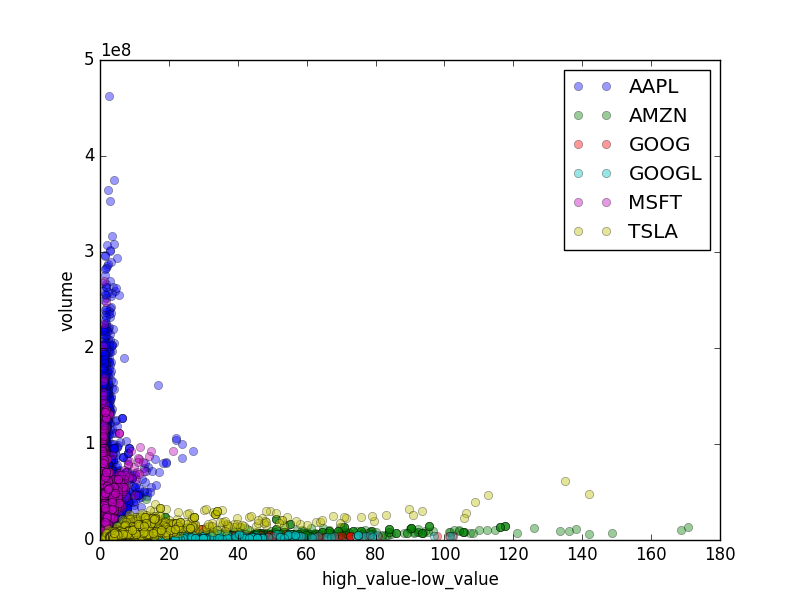

In [0]:
plt.clf()
query_3 = spark.sql('SELECT ticker_symbol, volume, low_high_diff FROM company_values').toPandas()

groups = query_3.groupby('ticker_symbol')
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['low_high_diff'], group['volume'], marker='o', linestyle='', label=name, alpha=0.4)
plt.xlabel('high_value-low_value')
plt.ylabel('volume')
ax.legend()
display(plt.show())

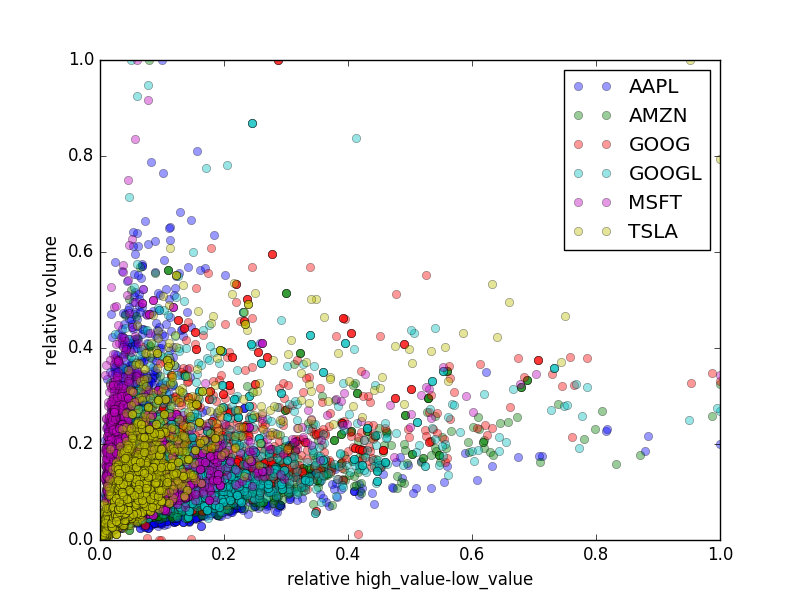

In [0]:
query_3['relative_volume'] = query_3['volume'].div(query_3.groupby('ticker_symbol')['volume'].transform('max'))
query_3['relative_lhdiff'] = query_3['low_high_diff'].div(query_3.groupby('ticker_symbol')['low_high_diff'].transform('max'))

groups = query_3.groupby('ticker_symbol')
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['relative_lhdiff'], group['relative_volume'], marker='o', linestyle='', label=name, alpha=0.4)
plt.xlabel('relative high_value-low_value')
plt.ylabel('relative volume')
ax.legend()
display(plt.show())

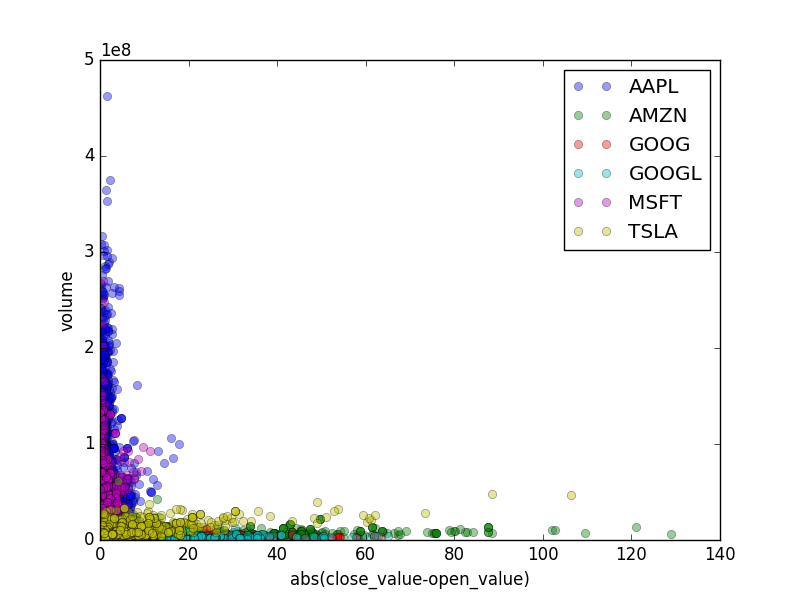

In [0]:
query_4 = spark.sql('SELECT ticker_symbol, volume, ABS(open_close_diff) as abs_open_close_diff FROM company_values').toPandas()

groups = query_4.groupby('ticker_symbol')
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['abs_open_close_diff'], group['volume'], marker='o', linestyle='', label=name, alpha=0.4)
ax.legend()
plt.xlabel('abs(close_value-open_value)')
plt.ylabel('volume')
display(plt.show())

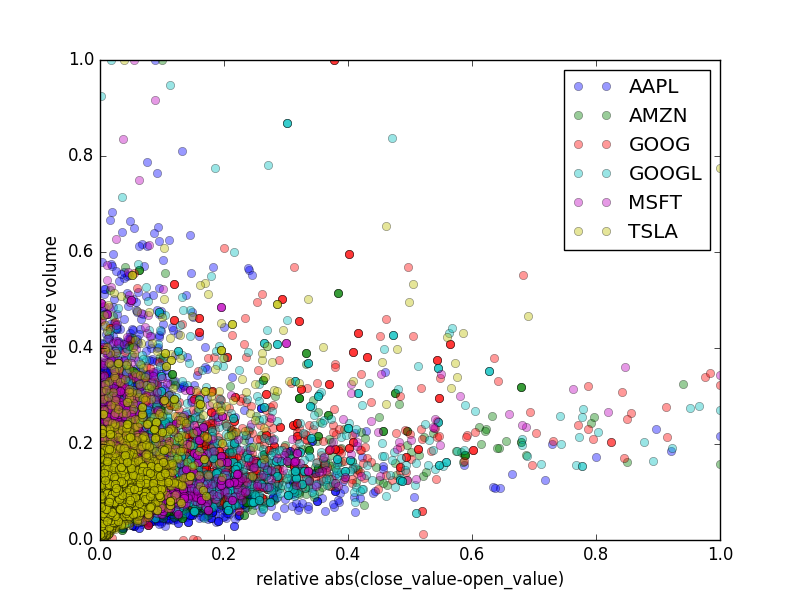

In [0]:
query_4['relative_volume'] = query_4['volume'].div(query_4.groupby('ticker_symbol')['volume'].transform('max'))
query_4['relative_ocadiff'] = query_4['abs_open_close_diff'].div(query_4.groupby('ticker_symbol')['abs_open_close_diff'].transform('max'))

groups = query_4.groupby('ticker_symbol')
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['relative_ocadiff'], group['relative_volume'], marker='o', linestyle='', label=name, alpha=0.4)
ax.legend()
plt.xlabel('relative abs(close_value-open_value)')
plt.ylabel('relative volume')
display(plt.show())

In [0]:
tweet_joined_df = tweet_df.join(company_tweet_df, tweet_df.tweet_id==company_tweet_df.tweet_id,"inner")\
.drop('tweet_id').drop('writer').drop('comment_num').drop('retweet_num').drop('like_num')
tweet_joined_df.show(5)

+--------------------+-------------------+-------------+
 body| post_date_ts|ticker_symbol|
+--------------------+-------------------+-------------+
Apple Inc. is doo...|2015-01-02 15:16:36| AAPL|
 $AAPL powering up|2015-01-02 20:25:22| AAPL|
Apple Sees Unusua...|2015-01-02 23:43:58| AAPL|
“@KeithMcCullough...|2015-01-03 13:53:43| AAPL|
"Poll: Only 5.4% ...|2015-01-03 15:38:51| AAPL|
+--------------------+-------------------+-------------+
only showing top 5 rows

In [0]:
sqlContext.registerDataFrameAsTable(tweet_joined_df, "tweet_joined")

In [0]:
%sql
SELECT ticker_symbol, MIN(post_date_ts) AS min_range, MAX(post_date_ts) AS max_range
FROM tweet_joined
GROUP BY ticker_symbol

ticker_symbol,min_range,max_range
AAPL,2015-01-01T00:00:57.000+0000,2019-12-31T23:55:53.000+0000
TSLA,2015-01-01T00:06:47.000+0000,2019-12-31T23:54:03.000+0000
GOOG,2015-01-01T00:26:09.000+0000,2019-12-31T23:50:32.000+0000
GOOGL,2015-01-01T00:26:44.000+0000,2019-12-31T23:43:26.000+0000
AMZN,2015-01-01T00:01:50.000+0000,2019-12-31T23:44:48.000+0000
MSFT,2015-01-01T00:11:17.000+0000,2019-12-31T23:55:37.000+0000


### Peak of Each Company

In [0]:
%sql
SELECT a.ticker_symbol, a.open_close_diff AS peak, a.day_date AS peak_date
FROM company_values a
INNER JOIN (
    SELECT ticker_symbol, MAX(open_close_diff) AS peak
    FROM company_values
    WHERE day_date>="2015-01-01" AND day_date<="2019-12-31"
    GROUP BY ticker_symbol
) b ON a.ticker_symbol = b.ticker_symbol AND a.open_close_diff = b.peak

ticker_symbol,peak,peak_date
AAPL,8.869999999999976,2018-12-26T00:00:00.000+0000
AMZN,102.00999999999999,2018-12-26T00:00:00.000+0000
GOOGL,50.450000000000045,2018-02-06T00:00:00.000+0000
GOOG,53.419999999999845,2018-02-06T00:00:00.000+0000
MSFT,5.420000000000002,2018-12-26T00:00:00.000+0000
TSLA,35.73000000000002,2018-08-07T00:00:00.000+0000


In [0]:
peak_aapl = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="AAPL")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>359-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=359))

peak_amzn = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="AMZN")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>359-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=359))

peak_googl = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="GOOGL")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>36-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=36))

peak_goog = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="GOOG")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>36-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=36))

peak_msft = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="MSFT")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>359-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=359))

peak_tsla = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="TSLA")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>218-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=218))

In [0]:
peak_aapl_count = peak_aapl.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
peak_amzn_count = peak_amzn.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
peak_googl_count = peak_googl.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
peak_goog_count = peak_goog.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
peak_msft_count = peak_msft.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
peak_tsla_count = peak_tsla.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()

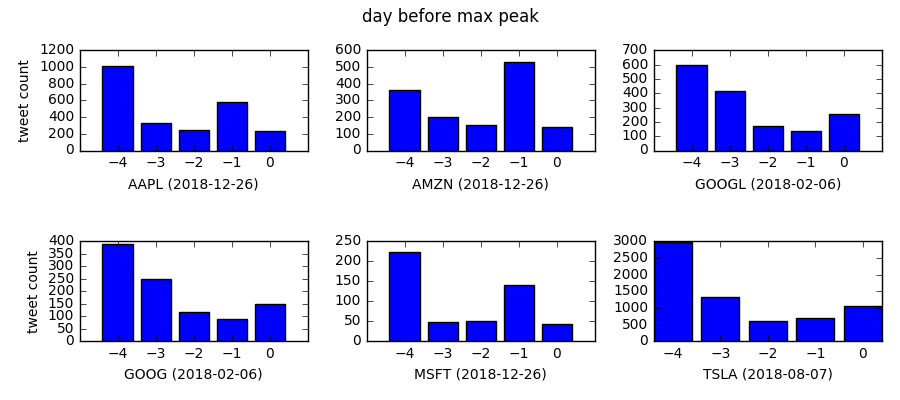

In [0]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 4), sharex=False, sharey=False)
plt.suptitle("day before max peak")
fig.subplots_adjust(bottom=0.8)
ax[0,0].set_ylabel('tweet count', fontsize=10)
ax[1,0].set_ylabel('tweet count', fontsize=10)
ax[0,0].bar((-4, -3, -2, -1, 0), 
            (peak_aapl_count.collect()[0]["count"],\
             peak_aapl_count.collect()[1]["count"],\
             peak_aapl_count.collect()[2]["count"],\
             peak_aapl_count.collect()[3]["count"],\
             peak_aapl_count.collect()[4]["count"]),align="center")
ax[0,0].set_xlabel('AAPL (2018-12-26)', fontsize=10)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)
ax[0,1].bar((-4, -3, -2, -1, 0), 
            (peak_amzn_count.collect()[0]["count"],\
             peak_amzn_count.collect()[1]["count"],\
             peak_amzn_count.collect()[2]["count"],\
             peak_amzn_count.collect()[3]["count"],\
             peak_amzn_count.collect()[4]["count"]),align="center")
ax[0,1].set_xlabel('AMZN (2018-12-26)', fontsize=10)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)
ax[0,2].bar((-4, -3, -2, -1, 0), 
            (peak_googl_count.collect()[0]["count"],\
             peak_googl_count.collect()[1]["count"],\
             peak_googl_count.collect()[2]["count"],\
             peak_googl_count.collect()[3]["count"],\
             peak_googl_count.collect()[4]["count"]),align="center")
ax[0,2].set_xlabel('GOOGL (2018-02-06)', fontsize=10)
ax[0,2].tick_params(axis='both', which='major', labelsize=10)
ax[0,2].tick_params(axis='both', which='minor', labelsize=8)
ax[1,0].bar((-4, -3, -2, -1, 0), 
            (peak_goog_count.collect()[0]["count"],\
             peak_goog_count.collect()[1]["count"],\
             peak_goog_count.collect()[2]["count"],\
             peak_goog_count.collect()[3]["count"],\
             peak_goog_count.collect()[4]["count"]),align="center")
ax[1,0].set_xlabel('GOOG (2018-02-06)', fontsize=10)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)
ax[1,1].bar((-4, -3, -2, -1, 0), 
            (peak_msft_count.collect()[0]["count"],\
             peak_msft_count.collect()[1]["count"],\
             peak_msft_count.collect()[2]["count"],\
             peak_msft_count.collect()[3]["count"],\
             peak_msft_count.collect()[4]["count"]),align="center")
ax[1,1].set_xlabel('MSFT (2018-12-26)', fontsize=10)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)
ax[1,2].bar((-4, -3, -2, -1, 0), 
            (peak_tsla_count.collect()[0]["count"],\
             peak_tsla_count.collect()[1]["count"],\
             peak_tsla_count.collect()[2]["count"],\
             peak_tsla_count.collect()[3]["count"],\
             peak_tsla_count.collect()[4]["count"]),align="center")
ax[1,2].set_xlabel('TSLA (2018-08-07)', fontsize=10)
ax[1,2].tick_params(axis='both', which='major', labelsize=10)
ax[1,2].tick_params(axis='both', which='minor', labelsize=8)
ax[0,0].set_xticks([-4,-3,-2,-1,0])
ax[0,1].set_xticks([-4,-3,-2,-1,0])
ax[0,2].set_xticks([-4,-3,-2,-1,0])
ax[1,0].set_xticks([-4,-3,-2,-1,0])
ax[1,1].set_xticks([-4,-3,-2,-1,0])
ax[1,2].set_xticks([-4,-3,-2,-1,0])
plt.autoscale()
fig.set_tight_layout(True)
display(plt.show())

In [0]:
top_peak_df = (tweet_joined_df\
               .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
               .filter(dayofyear(tweet_joined_df["post_date_ts"])>359-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=359))\
              .select("body").toPandas()
top_peak_df.count()

Out[ 39 ]: body 8391
dtype: int64

In [0]:
#Input: 'Text mining is to identify useful information.'
#Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
peak_tokens = [item for sublist in [text.split(" ") for text in top_peak_df['body'].unique()] for item in sublist]
len(peak_tokens)

Out[ 40 ]: 147848

In [0]:
peak_token_cnt = Counter(peak_tokens) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
valid_peak_tokens = list()
for f, cnt in peak_token_cnt.most_common():
  if(cnt>=5): #min_freq=5
    if(len(f)>=1 and f[0]=="#"): # find hastags
      valid_peak_tokens.append(f)
print("Size of features: ", len(valid_peak_tokens))

# build a mapping from tokens to indices
peak_tokens_dict = dict(zip(valid_peak_tokens, range(len(valid_peak_tokens))))
peak_tokens_dict

Size of features: 154
 Out[ 41 ]: {'#BTC': 31,
 '#sentiment': 65,
 '#news': 41,
 '#AR': 71,
 '#ChristmasEve': 114,
 '#Tesla': 1,
 '#FraudFormula': 67,
 '#StockNerds': 149,
 '#Futures': 121,
 '#daytrading': 40,
 '#technology': 74,
 '#SPX': 94,
 '#TEAMBILLIONAIRE': 35,
 '#NotSellingAShareBefore2500': 10,
 '#Trading': 51,
 '#silver': 7,
 '#Elliottwave': 39,
 '#economy': 60,
 '#apple': 77,
 '#StockMarket': 25,
 '#potstocks': 126,
 '#MAGA': 115,
 '#machinelearning': 99,
 '#stockmarket': 2,
 '#Rakuten': 80,
 '#market': 49,
 '#Apple': 11,
 '#Sears': 85,
 '#TeslaOwner': 70,
 '#steem': 63,
 '#markets': 93,
 '#stocks': 0,
 '#Trump': 129,
 '#crypto': 14,
 '#NYSE': 89,
 '#commodities': 5,
 '#lawsuit': 150,
 '#tesla': 19,
 '#Lithium': 143,
 '#TSLA': 139,
 '#review': 134,
 '#trademark': 130,
 '#ICO': 21,
 '#finance': 4,
 '#TrumpShutdown': 136,
 '#ecommerce': 69,
 '#DayTrading': 140,
 '#Energy': 106,
 '#digitalmarketing': 145,
 '#Model3': 37,
 '#ltc': 36,
 '#Kmart': 119,
 '#FANG': 102,
 '#research': 59,
 '#stock': 44,
 '#elliottwave': 13,
 '#blockchain': 12,
 '#FAANG': 56,
 '#AAPL': 53,
 '#AMZN': 83,
 '#StockMarketNews': 113,
 '#WallStreet': 58,
 '#google': 116,
 '#investments': 141,
 '#xrp': 32,
 '#nikkei': 122,
 '#ModelX': 148,
 '#EMHiveMind': 43,
 '#cryptocurrency': 15,
 '#Netflix': 92,
 '#Amazon': 17,
 '#NASDAQ': 61,
 '#bitcoin': 9,
 '#futures': 95,
 '#Facebook': 118,
 '#iPhone': 88,
 '#winning': 123,
 '#recession': 132,
 '#mcommerce': 142,
 '#Germany': 152,
 '#investing': 3,
 '#s': 133,
 '#mmj': 30,
 '#Investing': 111,
 '#BMM': 27,
 '#TheSociopathicBusinessModel': 101,
 '#Nasdaq': 54,
 '#TechNews': 107,
 '#eth': 23,
 '#DowJones': 147,
 '#innovation': 82,
 '#ElectricVehicle': 72,
 '#stockstowatch': 46,
 '#short': 151,
 '#Kopin': 124,
 '#business': 78,
 '#patent': 75,
 '#Dow': 117,
 '#politics': 125,
 '#TESLA': 24,
 '#gold': 6,
 '#Fed': 73,
 '#money': 34,
 '#tech': 18,
 '#Microsoft': 84,
 '#ethereum': 22,
 '#model3refund': 112,
 '#ElonMusk': 47,
 '#IP': 55,
 '#fintech': 29,
 '#traderead': 90,
 '#BearMarket': 98,
 '#retail': 97,
 '#FAANG,': 64,
 '#AugmentedReality': 81,
 '#TeslaModelX': 68,
 '#Tesra': 128,
 '#China': 57,
 '#ElectricCars': 108,
 '#cannabis': 120,
 '#Stocks': 52,
 '#Options': 50,
 '#doge': 28,
 '#Alphabet': 103,
 '#forex': 16,
 '#SpaceX': 48,
 '#startup': 91,
 '#growth': 135,
 '#pips': 153,
 '#MONEYGANG': 26,
 '#MerryChristmas': 86,
 '#today': 109,
 '#maxpain': 38,
 '#AI': 45,
 '#options': 20,
 '#TeslaModelS': 87,
 '#marijuanastocks': 138,
 '#BoringCompany': 127,
 '#MyTesla': 79,
 '#Financial': 104,
 '#ModelS': 137,
 '#Google': 66,
 '#profits': 33,
 '#TeslaMotors': 62,
 '#Markets': 131,
 '#TeslaModel3': 42,
 '#AIEYE': 146,
 '#profit': 100,
 '#Money': 144,
 '#AMAZON': 110,
 '#ideas': 105,
 '#EV': 76,
 '#trading': 8,
 '#AppleWatch': 96}

In [0]:
randomNum = random.sample(range(1,365),5)
print(randomNum)
random_df = (tweet_joined_df\
               .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
               .filter(dayofyear(tweet_joined_df["post_date_ts"]).isin(randomNum)))\
              .select("body").toPandas()
print(random_df.count())

[43, 181, 138, 161, 176]
body 8466
dtype: int64

In [0]:
random_tokens = [item for sublist in [text.split(" ") for text in random_df['body'].unique()] for item in sublist]
random_token_cnt = Counter(random_tokens) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
valid_random_tokens = list()
for f, cnt in random_token_cnt.most_common():
  if(cnt>=5): #min_freq=5
    if(len(f)>=1 and f[0]=="#"): # find hastags
      valid_random_tokens.append(f)
print("Size of features: ", len(valid_random_tokens))

# build a mapping from tokens to indices
random_tokens_dict = dict(zip(valid_random_tokens, range(len(valid_random_tokens))))
random_tokens_dict

Size of features: 122
 Out[ 43 ]: {'#BTC': 61,
 '#Tech': 74,
 '#sentiment': 55,
 '#AR': 18,
 '#CLOUDUNLOCK': 93,
 '#Tesla': 2,
 '#NYSE': 66,
 '#Futures': 75,
 '#daytrading': 80,
 '#technology': 51,
 '#Technology': 47,
 '#ethereum': 100,
 '#Trading': 21,
 '#Elliottwave': 29,
 '#unlock': 113,
 '#Investing': 98,
 '#apple': 114,
 '#Cryptocurrency': 115,
 '#MondayMotivation': 84,
 '#AppleInsider': 91,
 '#StockMarket': 5,
 '#lotto': 106,
 '#Apple': 6,
 '#Rakuten': 67,
 '#market': 63,
 '#stockmarket': 4,
 '#commodities': 70,
 '#stocks': 0,
 '#Trump': 121,
 '#crypto': 31,
 '#tariffs': 83,
 '#TSLA': 50,
 '#TOYOTA': 44,
 '#tesla': 10,
 '#ETF': 103,
 '#Bitcoin': 116,
 '#bonds': 64,
 '#finance': 11,
 '#silver': 62,
 '#iCloud': 120,
 '#Model3': 22,
 '#lottopick': 99,
 '#FANG': 37,
 '#stock': 25,
 '#elliottwave': 17,
 '#investing,': 86,
 '#Ganfeng': 88,
 '#FAANG': 90,
 '#MSFT': 119,
 '#AAPL': 9,
 '#AMZN': 40,
 '#cloud': 94,
 '#WallStreet': 32,
 '#investors': 102,
 '#cryptocurrency': 53,
 '#Energy': 68,
 '#Amazon': 14,
 '#NASDAQ': 20,
 '#option': 42,
 '#cnbc': 78,
 '#BYD': 101,
 '#moneyflow': 105,
 '#investing': 1,
 '#Google': 23,
 '#Arrow': 77,
 '#TheSociopathicBusinessModel': 109,
 '#OptionsTrading': 16,
 '#9to5Mac': 57,
 '#BITCOIN': 36,
 '#ElectricVehicle': 35,
 '#stockstowatch': 27,
 '#ES_F': 111,
 '#NISSAN': 60,
 '#swingtrading': 56,
 '#TheHunthttp://share.robinhood.com/benjamh245': 87,
 '#AugmentedReality': 39,
 '#nyse': 95,
 '#wearables': 54,
 '#fundamental': 92,
 '#gold': 59,
 '#lithium': 81,
 '#DragRace': 76,
 '#BMW': 104,
 '#money': 19,
 '#tech': 38,
 '#Microsoft': 28,
 '#aapl': 108,
 '#CRM': 117,
 '#trade': 33,
 '#PENNYSTOCKS': 58,
 '#ElonMusk': 8,
 '#nasdaq': 48,
 '#markets': 26,
 '#model3': 73,
 '#DigitalTransformation': 79,
 '#optionstrading': 13,
 '#GreysAnatomy': 69,
 '#iPhone': 65,
 '#Earnings': 82,
 '#pennystocks': 72,
 '#earnings': 89,
 '#China': 96,
 '#Stocks': 30,
 '#code': 118,
 '#Options': 7,
 '#TSLAQ': 46,
 '#SpaceX': 45,
 '#EVs': 110,
 '#smartglasses': 71,
 '#Alphabet': 41,
 '#AI': 43,
 '#maxpain': 34,
 '#options': 12,
 '#trading': 3,
 '#bitcoin': 15,
 '#online': 97,
 '#SP500': 52,
 '#TeslaModel3': 49,
 '#MAGA': 107,
 '#EV': 85,
 '#TeslaMotors': 24,
 '#DataScience': 112}

In [0]:
peak_random_same = list()
for i in valid_peak_tokens:
  for j in valid_random_tokens:
    if(i==j):
      peak_random_same.append(i)
peak_random_diff = np.setdiff1d(valid_peak_tokens,peak_random_same)
print(peak_random_diff)

['#AIEYE' '#AMAZON' '#AppleWatch' '#BMM' '#BearMarket' '#BoringCompany'
 '#ChristmasEve' '#DayTrading' '#Dow' '#DowJones' '#EMHiveMind'
 '#ElectricCars' '#FAANG,' '#Facebook' '#Fed' '#Financial' '#FraudFormula'
 '#Germany' '#ICO' '#IP' '#Kmart' '#Kopin' '#Lithium' '#MONEYGANG'
 '#Markets' '#MerryChristmas' '#ModelS' '#ModelX' '#Money' '#MyTesla'
 '#Nasdaq' '#Netflix' '#NotSellingAShareBefore2500' '#SPX' '#Sears'
 '#StockMarketNews' '#StockNerds' '#TEAMBILLIONAIRE' '#TESLA' '#TechNews'
 '#TeslaModelS' '#TeslaModelX' '#TeslaOwner' '#Tesra' '#TrumpShutdown'
 '#blockchain' '#business' '#cannabis' '#digitalmarketing' '#doge'
 '#ecommerce' '#economy' '#eth' '#fintech' '#forex' '#futures' '#google'
 '#growth' '#ideas' '#innovation' '#investments' '#lawsuit' '#ltc'
 '#machinelearning' '#marijuanastocks' '#mcommerce' '#mmj' '#model3refund'
 '#news' '#nikkei' '#patent' '#pips' '#politics' '#potstocks' '#profit'
 '#profits' '#recession' '#research' '#retail' '#review' '#s' '#short'
 '#startup' '#steem' '#today' '#trademark' '#traderead' '#winning' '#xrp']

In [0]:
#tweet_joined_df.filter(year("post_date_ts")=='2016').filter(dayofyear("post_date_ts")>=100)\
#        .groupBy(dayofyear("post_date_ts")).count().orderBy(dayofyear("post_date_ts"))

### Trough of Each Company

In [0]:
%sql
SELECT a.ticker_symbol, a.open_close_diff AS trough, a.day_date AS trough_date
FROM company_values a
INNER JOIN (
    SELECT ticker_symbol, MIN(open_close_diff) AS trough
    FROM company_values
    WHERE day_date>="2015-01-01" AND day_date<="2019-12-31"
    GROUP BY ticker_symbol
) b ON a.ticker_symbol = b.ticker_symbol AND a.open_close_diff = b.trough

ticker_symbol,trough,trough_date
AAPL,-9.099999999999994,2018-10-10T00:00:00.000+0000
AMZN,-121.11999999999989,2018-10-29T00:00:00.000+0000
GOOGL,-61.809999999999945,2018-10-29T00:00:00.000+0000
GOOG,-62.389999999999986,2018-10-29T00:00:00.000+0000
MSFT,-6.090000000000003,2018-10-24T00:00:00.000+0000
TSLA,-28.079999999999984,2018-02-08T00:00:00.000+0000


In [0]:
trough_aapl = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="AAPL")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>282-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=282))

trough_amzn = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="AMZN")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>301-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=301))

trough_googl = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="GOOGL")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>301-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=301))

trough_goog = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="GOOG")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>301-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=301))

trough_msft = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="MSFT")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>296-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=296))

trough_tsla = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="TSLA")\
             .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
             .filter(dayofyear(tweet_joined_df["post_date_ts"])>38-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=38))

In [0]:
trough_aapl_count = trough_aapl.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
trough_amzn_count = trough_amzn.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
trough_googl_count = trough_googl.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
trough_goog_count = trough_goog.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
trough_msft_count = trough_msft.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()
trough_tsla_count = trough_tsla.groupBy(dayofyear(tweet_joined_df["post_date_ts"])).count()\
             .orderBy(dayofyear(tweet_joined_df["post_date_ts"])).select("count").cache()

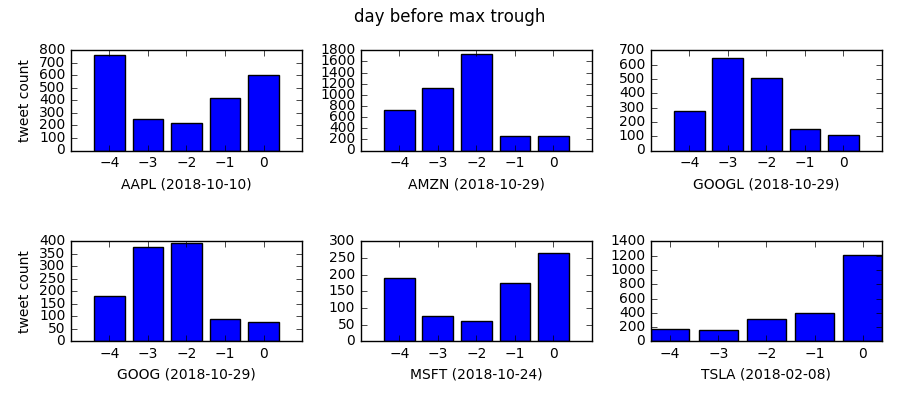

In [0]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 4), sharex=False, sharey=False)
plt.suptitle("day before max trough")
fig.subplots_adjust(bottom=0.8)
ax[0,0].set_ylabel('tweet count', fontsize=10)
ax[1,0].set_ylabel('tweet count', fontsize=10)
ax[0,0].bar((-4, -3, -2, -1, 0), 
            (trough_aapl_count.collect()[0]["count"],\
             trough_aapl_count.collect()[1]["count"],\
             trough_aapl_count.collect()[2]["count"],\
             trough_aapl_count.collect()[3]["count"],\
             trough_aapl_count.collect()[4]["count"]),align="center")
ax[0,0].set_xlabel('AAPL (2018-10-10)', fontsize=10)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)
ax[0,1].bar((-4, -3, -2, -1, 0), 
            (trough_amzn_count.collect()[0]["count"],\
             trough_amzn_count.collect()[1]["count"],\
             trough_amzn_count.collect()[2]["count"],\
             trough_amzn_count.collect()[3]["count"],\
             trough_amzn_count.collect()[4]["count"]),align="center")
ax[0,1].set_xlabel('AMZN (2018-10-29)', fontsize=10)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)
ax[0,2].bar((-4, -3, -2, -1, 0), 
            (trough_googl_count.collect()[0]["count"],\
             trough_googl_count.collect()[1]["count"],\
             trough_googl_count.collect()[2]["count"],\
             trough_googl_count.collect()[3]["count"],\
             trough_googl_count.collect()[4]["count"]),align="center")
ax[0,2].set_xlabel('GOOGL (2018-10-29)', fontsize=10)
ax[0,2].tick_params(axis='both', which='major', labelsize=10)
ax[0,2].tick_params(axis='both', which='minor', labelsize=8)
ax[1,0].bar((-4, -3, -2, -1, 0), 
            (trough_goog_count.collect()[0]["count"],\
             trough_goog_count.collect()[1]["count"],\
             trough_goog_count.collect()[2]["count"],\
             trough_goog_count.collect()[3]["count"],\
             trough_goog_count.collect()[4]["count"]),align="center")
ax[1,0].set_xlabel('GOOG (2018-10-29)', fontsize=10)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)
ax[1,1].bar((-4, -3, -2, -1, 0), 
            (trough_msft_count.collect()[0]["count"],\
             trough_msft_count.collect()[1]["count"],\
             trough_msft_count.collect()[2]["count"],\
             trough_msft_count.collect()[3]["count"],\
             trough_msft_count.collect()[4]["count"]),align="center")
ax[1,1].set_xlabel('MSFT (2018-10-24)', fontsize=10)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)
ax[1,2].bar((-4, -3, -2, -1, 0), 
            (trough_tsla_count.collect()[0]["count"],\
             trough_tsla_count.collect()[1]["count"],\
             trough_tsla_count.collect()[2]["count"],\
             trough_tsla_count.collect()[3]["count"],\
             trough_tsla_count.collect()[4]["count"]),align="center")
ax[1,2].set_xlabel('TSLA (2018-02-08)', fontsize=10)
ax[1,2].tick_params(axis='both', which='major', labelsize=10)
ax[1,2].tick_params(axis='both', which='minor', labelsize=8)
ax[0,0].set_xticks([-4,-3,-2,-1,0])
ax[0,1].set_xticks([-4,-3,-2,-1,0])
ax[0,2].set_xticks([-4,-3,-2,-1,0])
ax[1,0].set_xticks([-4,-3,-2,-1,0])
ax[1,1].set_xticks([-4,-3,-2,-1,0])
ax[1,2].set_xticks([-4,-3,-2,-1,0])
plt.autoscale()
fig.set_tight_layout(True)
display(plt.show())

In [0]:
top_trough_df = (tweet_joined_df.filter(tweet_joined_df['ticker_symbol']=="AMZN")\
                 .filter(year(tweet_joined_df["post_date_ts"])=='2018')\
                 .filter(dayofyear(tweet_joined_df["post_date_ts"])>301-5).filter(dayofyear(tweet_joined_df["post_date_ts"])<=301))\
                .select("body").toPandas()
top_trough_df.count()

Out[ 49 ]: body 4119
dtype: int64

In [0]:
trough_tokens = [item for sublist in [text.split(" ") for text in top_trough_df['body'].unique()] for item in sublist]
trough_token_cnt = Counter(trough_tokens) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
valid_trough_tokens = list()
for f, cnt in trough_token_cnt.most_common():
  if(cnt>=5): #min_freq=5
    if(len(f)>=1 and f[0]=="#"): # find hastags
      valid_trough_tokens.append(f)
print("Size of features: ", len(valid_trough_tokens))

# build a mapping from tokens to indices
trough_tokens_dict = dict(zip(valid_trough_tokens, range(len(valid_trough_tokens))))
trough_tokens_dict

Size of features: 96
 Out[ 50 ]: {'#StockNerds': 71,
 '#gaming': 92,
 '#machinelearning': 88,
 '#nikkei': 63,
 '#traders': 73,
 '#SwingTrading': 61,
 '#daytrading': 26,
 '#technology': 21,
 '#investors': 51,
 "#Amazon's": 91,
 '#twitch': 58,
 '#Trading': 11,
 '#silver': 8,
 '#Elliottwave': 18,
 '#Alexa': 89,
 '#article': 39,
 '#economy': 62,
 '#AWS': 31,
 '#economics': 86,
 '#StockMarket': 7,
 '#Rakuten': 34,
 '#market': 28,
 '#stockmarket': 2,
 '#advertising': 29,
 '#bullish': 72,
 '#stocks': 0,
 '#crypto': 25,
 '#Nasdaq': 43,
 '#NASDAQ': 35,
 '#investing': 3,
 '#bonds': 68,
 '#finance': 5,
 '#estate': 37,
 '#ecommerce': 52,
 '#DayTrading': 56,
 '#discordparty': 81,
 '#FANG': 15,
 '#stock': 27,
 '#elliottwave': 40,
 '#retail': 48,
 '#blockchain': 46,
 '#FAANG': 17,
 '#GDP': 59,
 '#AMZN': 12,
 '#revenue': 76,
 '#WallStreet': 32,
 '#RAKUTEN': 53,
 '#cryptocurrency': 55,
 '#Amazon': 1,
 '#commodities': 9,
 '#futures': 83,
 '#bloomberg': 38,
 '#recession': 74,
 '#bigdata': 80,
 '#bitcoin': 36,
 '#Investing': 69,
 '#OptionsTrading': 30,
 '#cloud': 14,
 '#stockstowatch': 90,
 '#ES_F': 77,
 '#amzn': 66,
 '#Algorithms': 95,
 '#Tesla': 87,
 '#CloudComputing': 19,
 '#gold': 6,
 '#money': 13,
 '#tech': 20,
 '#Microsoft': 94,
 '#amazon': 22,
 '#FAANG.': 60,
 '#markets': 23,
 '#doncasterisgreat': 44,
 '#traderead': 45,
 '#business': 82,
 '#FAANG,': 70,
 '#optionstrading': 65,
 '#TwitchCon': 84,
 '#Earnings': 47,
 '#DowJones': 50,
 '#earnings': 4,
 '#Stocks': 24,
 '#Options': 57,
 '#forex': 42,
 '#startup': 79,
 '#tastytrades': 67,
 '#stockmarketcrash': 41,
 '#superstocks': 78,
 '#Alphabet': 75,
 '#AI': 49,
 '#options': 16,
 '#GamingLife': 85,
 '#wsj': 33,
 '#Google': 54,
 '#AMAZON': 64,
 '#1': 93,
 '#trading': 10}

In [0]:
trough_random_same = list()
for i in valid_trough_tokens:
  for j in valid_random_tokens:
    if(i==j):
      trough_random_same.append(i)
trough_random_diff = np.setdiff1d(valid_trough_tokens,trough_random_same)
print(trough_random_diff)

['#1' '#AMAZON' '#AWS' '#Alexa' '#Algorithms' "#Amazon's" '#CloudComputing'
 '#DayTrading' '#DowJones' '#FAANG,' '#FAANG.' '#GDP' '#GamingLife'
 '#Nasdaq' '#RAKUTEN' '#StockNerds' '#SwingTrading' '#TwitchCon'
 '#advertising' '#amazon' '#amzn' '#article' '#bigdata' '#blockchain'
 '#bloomberg' '#bullish' '#business' '#discordparty' '#doncasterisgreat'
 '#ecommerce' '#economics' '#economy' '#estate' '#forex' '#futures'
 '#gaming' '#machinelearning' '#nikkei' '#recession' '#retail' '#revenue'
 '#startup' '#stockmarketcrash' '#superstocks' '#tastytrades' '#traderead'
 '#traders' '#twitch' '#wsj']